In [8]:
%matplotlib inline
#import matplotlib 
#matplotlib.use('Agg')
import os
import pandas as pd
from math import sqrt, log 
from functools import reduce
import numpy as np

# Needed on the cluster.
# matplotlib.use('Agg')
import matplotlib.pyplot as plt 
from matplotlib import rcParams

columnFormats = {
    "Ev" : '{:,.2e}'.format,
    "Ax" : '{:,.2f}'.format,
    "Nx" : '{:,.1f}'.format,
    "Te" : '{:,.2e}'.format,
    "Tr" : '{:,.2e}'.format
}

rcParams["text.usetex"] = True
rcParams["figure.figsize"] = (2.5, 2.5) 
rcParams["font.size"] = 8 

def parameter_study_dirs(studyName, meshType, algorithmName):
    """
    Return the list of OpenFOAM parameter study directory names for given study name
    and mesh type.
    """
    return [x for x in os.listdir(os.curdir) if os.path.isdir(x) 
         and studyName in x and "00" in x and meshType in x
         and algorithmName in x] 

def agglomerate_data(studyName, meshType, algorithmName):
    """
    Agglomerates all the data frames from a parameter study into a single dataframe.
    """
    dirs = parameter_study_dirs(studyName, meshType, algorithmName)
    dirs.sort()
    
    # Assumes the same number of iterations in the experiment: the index of every
    # CSV file should therefore have the same length.
    csvFileName = os.path.join(os.curdir, dirs[0], algorithmName + '.csv')
    csvDf = pd.read_csv(csvFileName)
    iterationList = list(csvDf.index)
    clmns = csvDf.columns
    

    # Data frames picked up from CSV files stored in simulation directories.
    dfs = []
    # A list of mesh resolution numbers N, where N^2 is the number of base mesh cells in 2D
    # and N^3 is the number of base mesh cells in 3D. Used for indexing specific cases. Nb 
    # stores the total number of cells used anyway.
    resolutionList = []
    for directory in dirs:  
        csvFileName = os.path.join(os.curdir, directory, algorithmName + '.csv')
        csvDf = pd.read_csv(csvFileName)
        meshResolutionN = int((csvDf["Nb"].iloc[0])**(1./3.))
        resolutionList.append(meshResolutionN)
        dfs.append(csvDf)
        
    # Store all data in a df with a multidimensional index 
    mIndex = pd.MultiIndex.from_product([resolutionList, iterationList], 
                                        names=['N', 'iteration'])
    
    agglDf = pd.concat(dfs) 
    agglDf.index = mIndex
    
    return agglDf

def box_plot_column(columnName, studyName, meshType, algorithmName, dFrame, xlabel, dim=3):
    """Plots a box plot of a column in a data frame against the mesh resolution number N."""
    resolutions = dFrame.index.levels[0]
    print(resolutions)
    dfCol= [dFrame.loc[i][columnName] for i in resolutions]
    medianprops = dict(linewidth=0.5, color='k')
    medianprops = dict(linestyle='-', linewidth=0.5, color='k')
    plt.boxplot(dfCol, notch=True, medianprops=medianprops) 
    plt.xticks(np.arange(1, len(resolutions) + 1), 
               ["$2^{%d}$" % (int(log(i,2)) * dim)  for i in resolutions])
    columnNameList = list(columnName)
    plt.xlabel(xlabel)
    plt.ylabel("$%s_%s$" % (columnNameList[0], columnNameList[1]))
    plt.title("%s (%s-cells)" % (studyName, meshType)) 
    pdfName = "%s%s%s%s.pdf" % (algorithmName, studyName, meshType, columnName)
    plt.savefig(pdfName)
    plt.savefig(os.path.join(os.environ["INIT_FIG_PATH"], pdfName), bbox_inches='tight') 
    

# TODO: reset once smci / ccmi algorithms work properly again
#smciDf = agglomerate_data('smci')
#ccmiDf = agglomerate_data('ccmi')
povofHexDf = agglomerate_data('volMeshResStudy', 'hex', 'povof')
povofTetDf = agglomerate_data('volMeshResStudy', 'tet', 'povof')
povofPolyDf = agglomerate_data('volMeshResStudy', 'poly', 'povof')

resolutionLabel = "$N_b$ number of bulk mesh cells."

Int64Index([3, 7, 15, 31, 63, 127], dtype='int64', name='N')


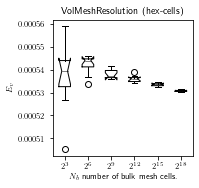

In [4]:
box_plot_column("Ev", "VolMeshResolution", "hex", "POVOF", povofHexDf, xlabel=resolutionLabel)

Int64Index([7, 12, 21, 39, 76, 149], dtype='int64', name='N')


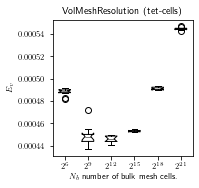

In [7]:
box_plot_column("Ev", "VolMeshResolution", "tet", "POVOF", povofTetDf, xlabel=resolutionLabel)

Int64Index([5, 12, 20, 36, 67, 98], dtype='int64', name='N')


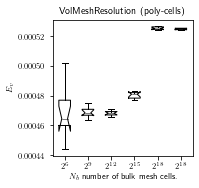

In [9]:
box_plot_column("Ev", "VolMeshResolution", "poly", "POVOF", povofPolyDf, xlabel=resolutionLabel)

In [ ]:
box_plot_column("Ev", "SMCI", "hex", smciDf, xlabel=resolutionLabel)

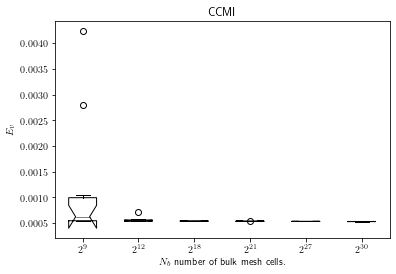

In [2]:
box_plot_column("Ev", "CCMI", ccmiDf, xlabel=resolutionLabel)

In [ ]:
box_plot_column("Te", "SMCI", smciDf, xlabel=resolutionLabel)

In [ ]:
box_plot_column("Te", "CCMI", ccmiDf, xlabel=resolutionLabel)

In [ ]:
box_plot_column("Te", "POVOF", povofDf, xlabel=resolutionLabel)

In [ ]:
## Tabular data representation, loop over resolutions and average the dframe.
def int_form(x):
    return "%d" % round(x,1)

def sci_form(x):
    return "%.2e" % x

def float_form(x):
    return "%.2f" % x

def fig_pathname(filename):
    return os.path.join(os.environ["INIT_FIG_PATH"], filename)

def tab_pathname(filename):
    return os.path.join(os.environ["INIT_TAB_PATH"], filename)

def mean_df(df, formatters):
    
    meanSeries = []
    resolutions = df.index.levels[0]
    for resolution in resolutions: 
        meanSeries.append(df.loc[resolution].mean())
    
    meanDf = pd.DataFrame(meanSeries, index=resolutions)

    return meanDf

smci_formatters =[int_form, int_form, sci_form, sci_form, sci_form, 
                  sci_form, int_form, int_form, int_form, int_form]

smciMeanDf = mean_df(smciDf, smci_formatters)

smciMeanDf.to_latex(buf=tab_pathname("SMCImean.tex"),
                    formatters=smci_formatters)


In [ ]:
smciCorr = smciMeanDf.corr()
smciCorr["Te"].sort_values(ascending=False)

In [ ]:
ccmi_formatters =[int_form, int_form, sci_form, sci_form, sci_form, 
                  int_form, int_form, int_form, int_form, int_form]

ccmiMeanDf = mean_df(ccmiDf, ccmi_formatters)

ccmiMeanDf.to_latex(buf=tab_pathname("CCMImean.tex"), 
                    formatters=ccmi_formatters)

In [ ]:
povof_formatters =[int_form, int_form, sci_form, sci_form, sci_form, 
                  int_form, int_form, int_form, int_form, int_form]

povofMeanDf = mean_df(povofDf, povof_formatters)

povofMeanDf.to_latex(buf=tab_pathname("POVOFmean.tex"), 
                    formatters=povof_formatters)

This plot shows that the both algorithms scale linear with respect to the size of the problem, that has been increased in term of the number of cells of the base mesh $N_b$. Since almost all of the computational time is spent in the intersection operations, this will determine the overall speed of execution. 

In [ ]:
plt.plot(ccmiMeanDf["Nb"], ccmiMeanDf["Te"], label="$T_e$ CCMI", 
         marker='o', markersize='4', color='k', ls=":", lw=0.5)

plt.plot(smciMeanDf["Nb"], smciMeanDf["Te"], label="$T_e$ SMCI", 
         marker='^', markersize='4', color='k', ls="--", lw=0.5)

# TODO: there is no Tx in the metrics written by the test application
#plt.plot(smciMeanDf["Nb"], smciMeanDf["Tx"], label="$T_x$ SMCI", 
#         marker='x', markersize='4', color='k', ls="--", lw=0.5)

locs = [2e05, 3e06, 4e06]
labels = ["$2\cdot10^5$", "$3\cdot10^6$", "$4\cdot10^6$"] 
plt.xticks(locs,labels)

plt.xlabel("$N_b$ number of base mesh cells.")
plt.ylabel("$T_e$ in seconds")
plt.legend()
plt.loglog()
plt.savefig(fig_pathname("TeNbLogLog.pdf"), bbox_inches="tight")

In [ ]:
fig = plt.figure()

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()

lns1 = ax2.plot(ccmiMeanDf["Nx"], ccmiMeanDf["Te"], label="$T_e$ CCMI", 
         marker='o', markersize='4', color='k', ls=":", lw=0.5)
ax2.set_xlabel("$Nx$ number of intersections CCMI.")
         
lns2 = ax1.plot(smciMeanDf["Nx"], smciMeanDf["Te"], label="$T_e$ SMCI", 
         marker='^', markersize='4', color='k', ls="--", lw=0.5)
lns3 = ax1.plot(smciMeanDf["Nx"], smciMeanDf["Tx"], label="$T_x$ SMCI", 
         marker='x', markersize='4', color='k', ls="--", lw=0.5)

ax1.set_xlabel("$Nx$ number of intersections SMCI.")

lns = lns1 + lns2 + lns3

labs = [l.get_label() for l in lns]


ax1.set_ylabel("$T_e$ in seconds")
ax1.legend(lns,labs, loc="upper left")
plt.savefig(fig_pathname("TeNx.pdf"), bbox_inches="tight")

In [ ]:
plt.plot(ccmiMeanDf["Nb"], ccmiMeanDf["Te"] / smciMeanDf["Te"],
         marker='o', markersize='4', color='k', ls=":", lw=0.5)
plt.grid()
locsy, labelsy = plt.yticks()
locs, labels = plt.xticks()
#locs = [1e02, 1e04, 1e06, 2e06, 4e06]
#labels = ["%1e" % i for i in locs if i > 0]
plt.xticks(locs,labels)
plt.semilogx()
plt.xlabel("$N_b$ number of base mesh cells.")
plt.ylabel("$T_e$ ratio CCMI / SMCI.")
plt.savefig(fig_pathname("TeRatioNb.pdf"), bbox_inches="tight")

In [ ]:
fig = plt.figure()

fig = plt.figure()
ax1 = fig.add_subplot(111)
#ax2 = ax1.twinx()
    
ax1.plot(ccmiMeanDf["Nb"], ccmiMeanDf["Nx"], label="$N_x$ CCMI", 
         lw=0.5, marker='o', markersize=4, color='k')
ax1.plot(smciMeanDf["Nb"], smciMeanDf["Nx"], label="$N_x$ SMCI", 
         lw=0.5, marker='^', markersize=4, color='k')
ax1.set_xlabel("$N_b$ number of base mesh cells.")
ax1.set_ylabel("$N_x$ number intersections SMCI.")
#ax1.set_ylabel("$N_x$ number intersections CCMI.")
ax1.legend(loc="upper center")
#ax2.legend(loc="lower right")
plt.savefig(fig_pathname("NxNb.pdf"), bbox_inches="tight")

In [ ]:
fig = plt.figure()

fig = plt.figure()
ax1 = fig.add_subplot(111)

ccmiMeanDfFirst = ccmiMeanDf.head(6)
smciMeanDfFirst = smciMeanDf.head(6)

ax1.plot(ccmiMeanDfFirst["Nb"], ccmiMeanDfFirst["Nx"], label="$N_x$ CCMI", 
         lw=0.5, marker='o', markersize=4, color='k')

ax1.plot(smciMeanDfFirst["Nb"], smciMeanDfFirst["Nx"], label="$N_x$ SMCI", 
         lw=0.5, marker='^', markersize=4, color='k')

ax1.set_xlabel("$N_b$ number of base mesh cells.")
ax1.set_ylabel("$N_x$ number intersections SMCI.")

#ax1.set_ylabel("$N_x$ number intersections CCMI.")
ax1.legend(loc="upper center")
#ax2.legend(loc="lower right")
#ax1.semilogy()
plt.savefig(fig_pathname("NxNb.pdf"), bbox_inches="tight")